In [1]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import anndata
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

In [4]:
sc.settings.set_figure_params(dpi=50, facecolor="white")
warnings.filterwarnings('ignore')

### Loading and filtering data

In [5]:
# Unite immune cells
files = [
    "bcells_final.h5ad",
    "cd4tcells_final.h5ad",
    "cd8tcells_final.h5ad",
    "ilc_final.h5ad",
    "myeloid_final.h5ad"
]

adatas = [sc.read(f) for f in files]
adata_immune = adatas[0].concatenate(adatas[1:], join='outer')

In [6]:
# Analyze the expression of hub genes obtained on the basis of the previous analysis
genes_of_interest = [
    "CXCL8", "CSF2", "TGFB1", "CSF3", "TIMP1",
    "IL1B", "PECAM1", "FGF2", "IL6", "CCL2"
]

In [7]:
# Select data for patients with Crohn's disease before therapy
adata_cd_pre = adata_immune[
    (adata_immune.obs["Disease"] == "CD") &
    (adata_immune.obs["Treatment"] == "Pre")
]

# Divide into responders and non-responders
adata_responder = adata_cd_pre[adata_cd_pre.obs["Remission_status"] == "Remission"]
adata_non_responder = adata_cd_pre[adata_cd_pre.obs["Remission_status"] == "Non_Remission"]

# Filtering data by genes of interest
adata_responder_filtered = adata_responder[:, genes_of_interest]
adata_non_responder_filtered = adata_non_responder[:, genes_of_interest]

### General analysis of genes of interest

In [8]:
# Calculate the overall expression rate of the genes of interest
sc.tl.score_genes(adata_cd_pre, genes_of_interest, score_name="score")

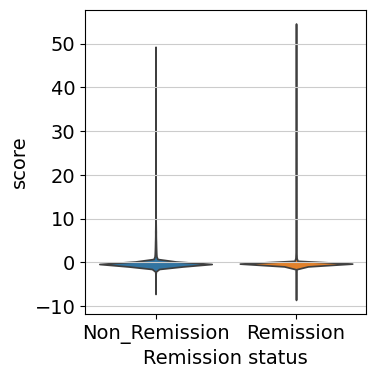

In [9]:
sc.pl.violin(
    adata_cd_pre,
    keys="score",
    groupby="Remission_status",
    stripplot=False,
    jitter=False,
    show=True
)

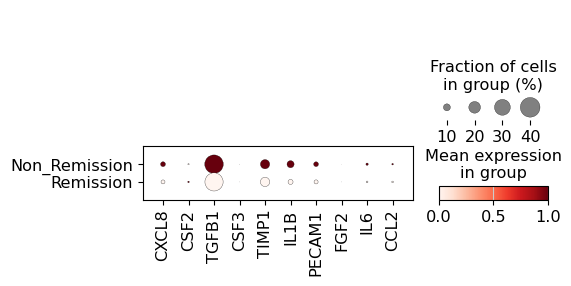

In [10]:
sc.pl.dotplot(
    adata_cd_pre,
    var_names=genes_of_interest,
    groupby="Remission_status",   
    standard_scale="var",        
    dendrogram=False
)

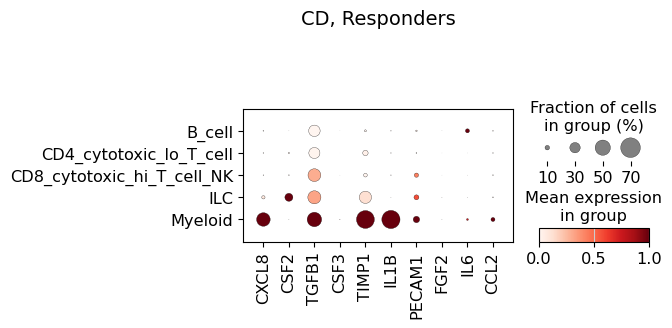

In [11]:
sc.pl.dotplot(
    adata_responder_filtered,
    var_names=genes_of_interest,
    groupby="bucket", 
    standard_scale="var",      
    dendrogram=False,
    title="CD, Responders" 
)

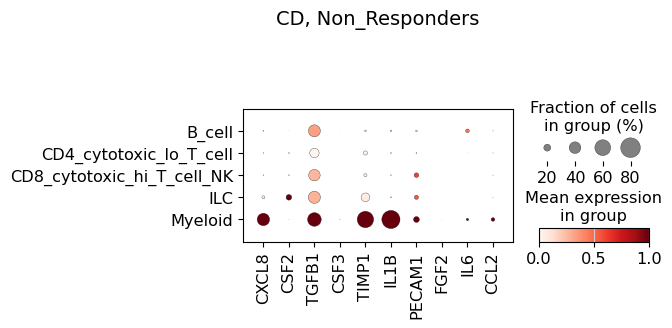

In [12]:
sc.pl.dotplot(
    adata_non_responder_filtered,
    var_names=genes_of_interest,
    groupby="bucket",   
    standard_scale="var",     
    dendrogram=False,
    title="CD, Non_Responders" 
)

### Myeloid cell analysis¶

In [13]:
# Select and filter myeloid cells
adata_responder_myel = adata_responder[adata_responder.obs["bucket"] == "Myeloid"]
adata_non_responder_myel = adata_non_responder[adata_non_responder.obs["bucket"] == "Myeloid"]

adata_responder_myel_filtered = adata_responder_myel[:, genes_of_interest]
adata_non_responder_myel_filtered = adata_non_responder_myel[:, genes_of_interest]

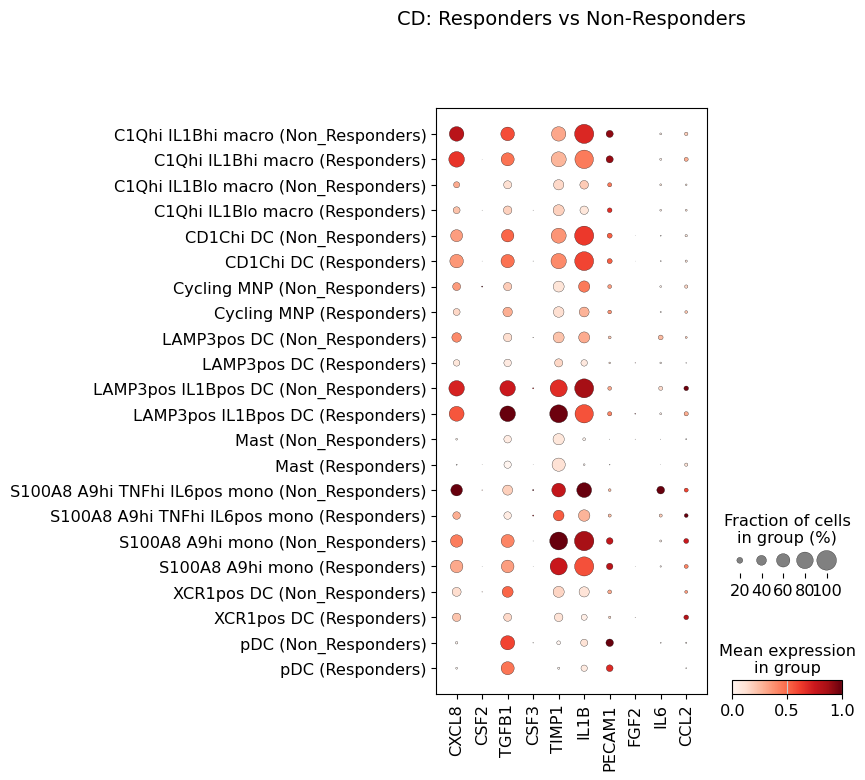

In [14]:
adata_responder_myel_filtered.obs["response_group"] = "Responders"
adata_non_responder_myel_filtered.obs["response_group"] = "Non_Responders"

adata_combined = anndata.concat(
    [adata_responder_myel_filtered, adata_non_responder_myel_filtered],
    join="outer",
    label="response_status",
    keys=["Responders", "Non_Responders"],
)

adata_combined.obs["combined_group"] = (
    adata_combined.obs["final_analysis"].astype(str) + 
    " (" + 
    adata_combined.obs["response_group"].astype(str) + 
    ")"
)

sc.pl.dotplot(
    adata_combined,
    var_names=genes_of_interest,
    groupby="combined_group",  
    standard_scale="var",     
    dendrogram=False,
    title="CD: Responders vs Non-Responders"
)

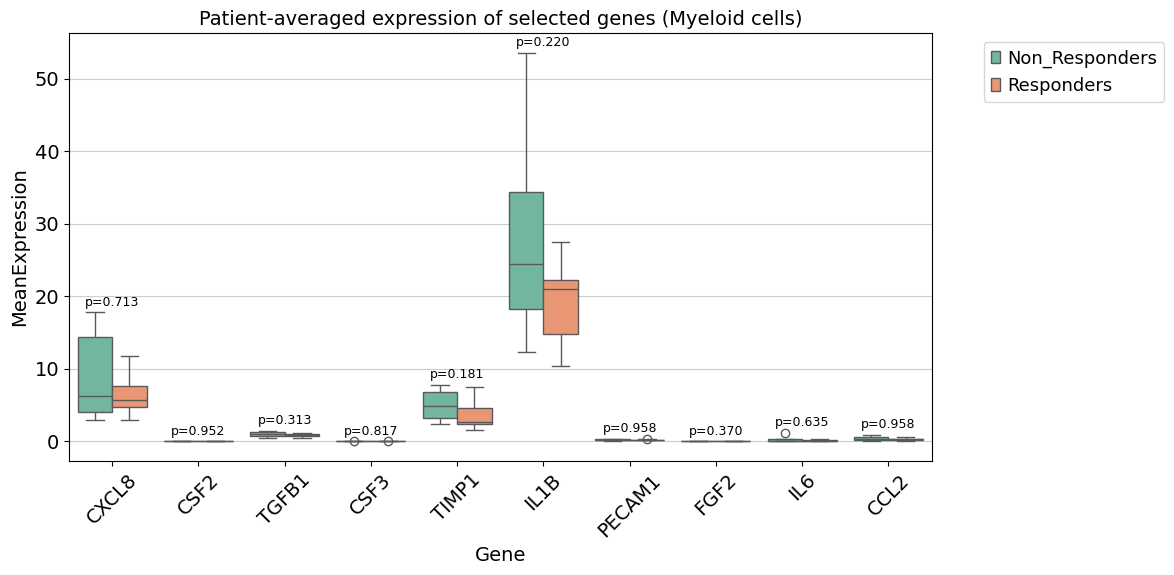

In [15]:
X = adata_combined[:, genes_of_interest].X
if not isinstance(X, np.ndarray):
    X = X.toarray()

df = pd.DataFrame(X, columns=genes_of_interest)
df["Response"] = adata_combined.obs["response_group"].values
df["Patient"] = adata_combined.obs["Patient"].values

df_avg = df.groupby(["Patient", "Response"]).mean().reset_index()

df_melted = df_avg.melt(id_vars=["Patient", "Response"], var_name="Gene", value_name="MeanExpression")

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_melted,
    x="Gene",
    y="MeanExpression",
    hue="Response",
    palette="Set2"
)

for i, gene in enumerate(genes_of_interest):
    subset = df_melted[df_melted["Gene"] == gene]
    r = subset[subset["Response"] == "Responders"]["MeanExpression"].dropna()
    nr = subset[subset["Response"] == "Non_Responders"]["MeanExpression"].dropna()

    if len(r) >= 2 and len(nr) >= 2:
        stat, pval = mannwhitneyu(r, nr, alternative="two-sided")
        y_max = subset["MeanExpression"].max()
        ax.text(i, y_max +0.5, f"p={pval:.3f}", ha='center', va='bottom', fontsize=9)
    else:
        ax.text(i, subset["MeanExpression"].max() * 1.05, "n/a", ha='center', va='bottom', fontsize=9, color="gray")

plt.title("Patient-averaged expression of selected genes (Myeloid cells)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

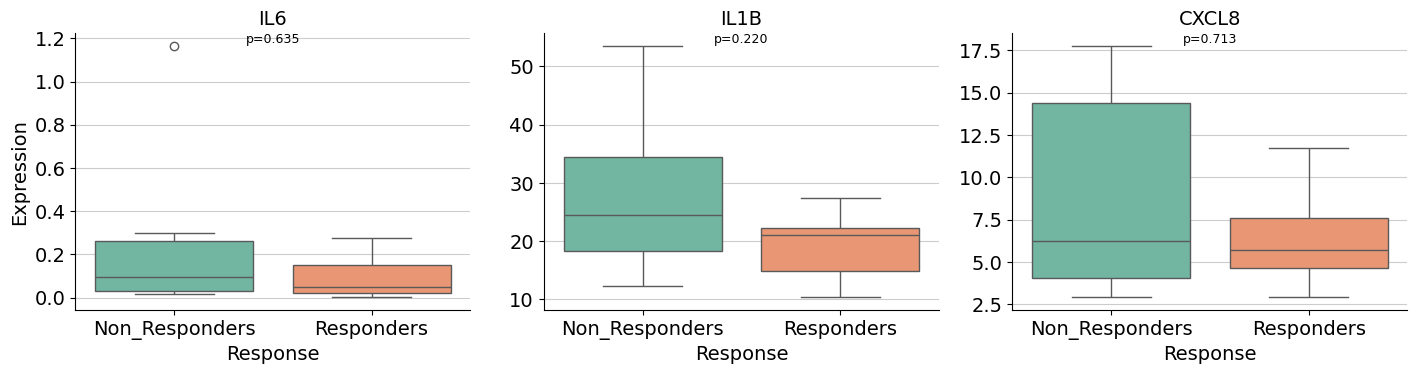

In [16]:
selected_genes = ["IL6", "IL1B", "CXCL8"]

expr = adata_combined[:, selected_genes].X
if hasattr(expr, "toarray"):
    expr = expr.toarray()

df = pd.DataFrame(expr, columns=selected_genes)
df["Response"] = adata_combined.obs["response_group"].values
df["Patient"] = adata_combined.obs["Patient"].values

df_patient_aggregated = df.groupby(["Patient", "Response"])[selected_genes].mean().reset_index()

df_melted = df_patient_aggregated.melt(
    id_vars=["Patient", "Response"],
    var_name="Gene",
    value_name="Expression"
)

g = sns.FacetGrid(df_melted, col="Gene", sharey=False, height=4, aspect=1.2)
g.map_dataframe(sns.boxplot, x="Response", y="Expression", palette="Set2")

for ax, gene in zip(g.axes.flat, selected_genes):
    subset = df_melted[df_melted["Gene"] == gene]
    r = subset[subset["Response"] == "Responders"]["Expression"].dropna()
    nr = subset[subset["Response"] == "Non_Responders"]["Expression"].dropna()

    if len(r) >= 2 and len(nr) >= 2:
        stat, pval = mannwhitneyu(r, nr, alternative="two-sided")
        y_max = subset["Expression"].max()
        ax.text(0.5, y_max * 1, f"p={pval:.3f}", ha="center", va="bottom", fontsize=9)
    else:
        ax.text(0.5, subset["Expression"].max() * 1.05, "n/a", ha="center", va="bottom", fontsize=9, color="gray")

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Response", "Expression")
plt.tight_layout()
plt.show()

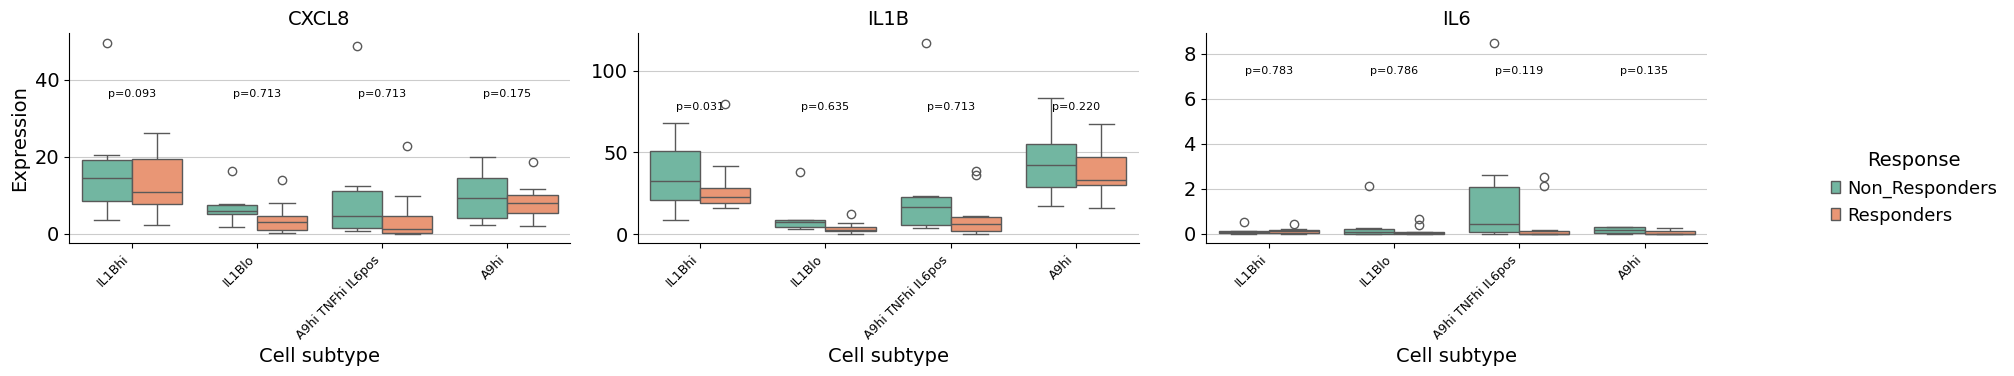

In [17]:
genes_of_interest = ["CXCL8", "IL1B", "IL6"]

selected_clusters = [
    "C1Qhi IL1Blo macro",
    "C1Qhi IL1Bhi macro",
    "S100A8 A9hi mono",
    "S100A8 A9hi TNFhi IL6pos mono"
]

cluster_rename_map = {
    "C1Qhi IL1Blo macro": "IL1Blo",
    "C1Qhi IL1Bhi macro": "IL1Bhi",
    "S100A8 A9hi mono": "A9hi",
    "S100A8 A9hi TNFhi IL6pos mono": "A9hi TNFhi IL6pos"
}

pval_ypos = {
    "CXCL8": 35,
    "IL1B": 75,
    "IL6": 7
}

adata_filtered = adata_combined[adata_combined.obs["final_analysis"].isin(selected_clusters), :]
adata_filtered = adata_filtered[:, genes_of_interest]

expr_df = pd.DataFrame(
    adata_filtered.X.toarray(),  # .X — scipy sparse matrix
    columns=genes_of_interest
)
expr_df["Subtype"] = adata_filtered.obs["final_analysis"].map(cluster_rename_map).values
expr_df["Response"] = adata_filtered.obs["response_group"].values
expr_df["Patient"] = adata_filtered.obs["Patient"].values

# Агрегация по пациентам
expr_patient_aggregated = (
    expr_df.groupby(["Patient", "Subtype", "Response"])[genes_of_interest]
    .mean()
    .reset_index()
)

expr_melted = expr_patient_aggregated.melt(
    id_vars=["Patient", "Subtype", "Response"],
    var_name="Gene",
    value_name="Expression"
)

g = sns.FacetGrid(expr_melted, col="Gene", col_wrap=3, sharey=False, height=4, aspect=1.3)
g.map_dataframe(sns.boxplot, x="Subtype", y="Expression", hue="Response", palette="Set2")

for ax in g.axes.flat:
    gene = ax.get_title().split('=')[1].strip()
    y_pval = pval_ypos.get(gene, 1.1)
    for i, subtype in enumerate(cluster_rename_map.values()):
        subset = expr_melted[
            (expr_melted["Gene"] == gene) & (expr_melted["Subtype"] == subtype)
        ]
        r = subset[subset["Response"] == "Responders"]["Expression"].dropna()
        nr = subset[subset["Response"] == "Non_Responders"]["Expression"].dropna()

        if len(r) >= 2 and len(nr) >= 2:
            stat, pval = mannwhitneyu(r, nr, alternative="two-sided")
            ax.text(i, y_pval, f"p={pval:.3f}", ha='center', va='bottom', fontsize=8, color='black')
        else:
            ax.text(i, y_pval, "n/a", ha='center', va='bottom', fontsize=8, color='gray')

for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)

g.add_legend(title="Response", bbox_to_anchor=(1.05, 0.5), loc="center left")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Cell subtype", "Expression")

plt.tight_layout()
plt.show()

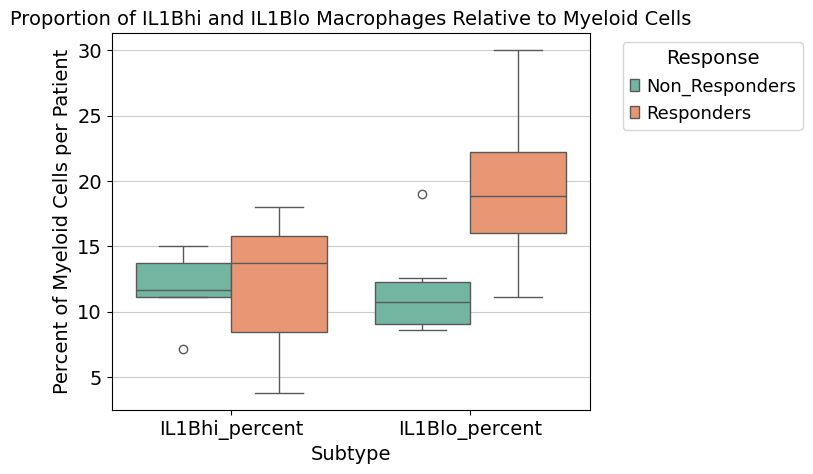

IL1Bhi_percent: Mann–Whitney U p-value = 0.635
IL1Blo_percent: Mann–Whitney U p-value = 0.011


In [18]:
macro_mask = adata_combined.obs["final_analysis"].isin(["C1Qhi IL1Bhi macro", "C1Qhi IL1Blo macro"])
adata_macro = adata_combined[macro_mask]

obs_df = adata_macro.obs[["final_analysis", "response_group", "Patient"]].copy()

# Подсчитываем количество клеток каждого типа на пациента
count_table = (
    obs_df
    .groupby(["Patient", "final_analysis"])
    .size()
    .unstack(fill_value=0)
)

# Получаем количество всех миелоидных клеток на пациента (в adata_combined все клетки миелоидные)
myeloid_count_table = adata_combined.obs.groupby("Patient").size()

# Добавляем общую сумму миелоидных клеток и считаем доли IL1Bhi и IL1Blo макрофагов
count_table["total_myeloid"] = myeloid_count_table
count_table["IL1Bhi_percent"] = 100 * count_table.get("C1Qhi IL1Bhi macro", 0) / count_table["total_myeloid"]
count_table["IL1Blo_percent"] = 100 * count_table.get("C1Qhi IL1Blo macro", 0) / count_table["total_myeloid"]

count_table["response_group"] = obs_df.drop_duplicates("Patient").set_index("Patient")["response_group"]

plot_df = count_table.reset_index().melt(
    id_vars=["Patient", "response_group"],
    value_vars=["IL1Bhi_percent", "IL1Blo_percent"],
    var_name="Subtype",
    value_name="Percent"
)

plt.figure(figsize=(8, 5))
sns.boxplot(data=plot_df, x="Subtype", y="Percent", hue="response_group", palette="Set2")

plt.ylabel("Percent of Myeloid Cells per Patient")
plt.title("Proportion of IL1Bhi and IL1Blo Macrophages Relative to Myeloid Cells")
plt.legend(title="Response", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

for subtype in ["IL1Bhi_percent", "IL1Blo_percent"]:
    r = count_table[count_table["response_group"] == "Responders"][subtype]
    nr = count_table[count_table["response_group"] == "Non_Responders"][subtype]
    stat, pval = mannwhitneyu(r, nr, alternative="two-sided")
    print(f"{subtype}: Mann–Whitney U p-value = {pval:.3f}")